In [4]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs, reduce_variance, reduce_min, reduce_max
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from utils.basic_units import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [5]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [6]:
k = 10 # Top 10% highest l2-magnitude filters

In [ ]:
def get_F_angle(F):
	
	F = tf.expand_dims(F, -1)
	_, a = getSymAntiSymTF(F)
	a_mag = reduce_euclidean_norm(a, axis=[0,1])[:, 0]
	theta = getSobelTF(F)[:, 0]
	#print(a_mag.shape)
	x =a_mag*np.cos((theta))
	y = a_mag*np.sin((theta))


	cov = np.cov([x,y])
	e_val, e_vec = np.linalg.eigh(cov)
	e_vec = e_vec[:, np.argmax(e_val)]
	e_val = np.max(e_val)

	new_vec =    ((e_vec[0] * x + e_vec[1]*y)/(e_vec[0]**2+e_vec[1]**2))[:, None] * e_vec
	new_vec = np.mean(new_vec, axis=0)

	if any((np.sign(new_vec)-np.sign(e_vec))!=0) :
		print("DOWN", e_vec, new_vec)
	else:
		print("OK", e_vec, new_vec)
	'''if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
		e_vec *= -1'''
		#print(e_val, e_vec)
	#print(np.arctan2(e_vec[1], e_vec[0]))
	return np.arctan2(new_vec[1], new_vec[0])

FL (3, 3, 512, 512)
AMAG (512, 512)
OK [-0.16541915  0.98622336] [-0.00010541  0.00062847]
DOWN [0.03933334 0.99922614] [-1.4067064e-06 -3.5736011e-05]
DOWN [0.0355051 0.9993695] [-1.8822633e-05 -5.2980473e-04]
DOWN [0.06247129 0.99804676] [-5.6979377e-05 -9.1030699e-04]
DOWN [0.15210818 0.98836385] [-0.00017735 -0.00115239]
OK [0.13490285 0.99085883] [9.087422e-05 6.674694e-04]
DOWN [-0.95601976  0.29330226] [ 0.00179502 -0.0005507 ]
DOWN [-0.09084856  0.99586472] [ 9.8380711e-05 -1.0784309e-03]
OK [-0.3052977   0.95225696] [-0.00024481  0.0007636 ]
OK [-0.99991834 -0.01277913] [-5.7246315e-04 -7.3161723e-06]
DOWN [-0.00768414  0.99997048] [ 4.334428e-06 -5.640583e-04]
DOWN [0.06084508 0.99814722] [-2.4872443e-05 -4.0802569e-04]
OK [-0.14039274  0.99009589] [-0.00032565  0.00229658]
DOWN [-0.74880167 -0.66279413] [0.00072166 0.00063877]
DOWN [-0.1332026   0.99108883] [ 3.6734735e-05 -2.7332318e-04]
DOWN [-0.89401778  0.44803148] [ 0.00031709 -0.00015891]
OK [-0.46100378  0.88739817] [

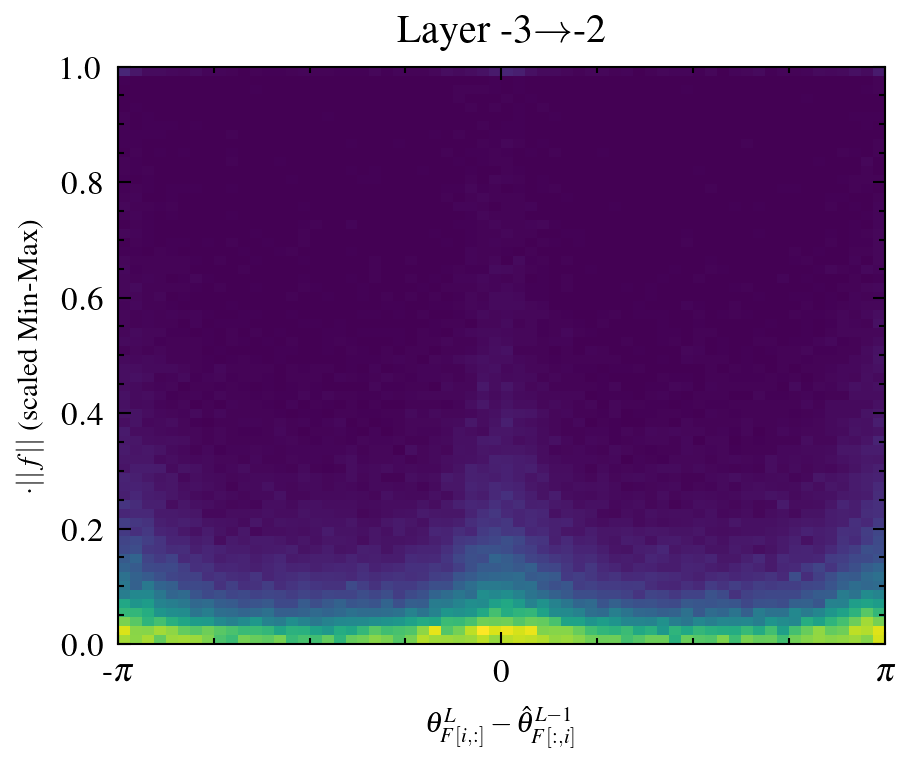

In [18]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)

 
l_num = -3
#top10Fprev=topKfilters(model, l_num-1, k=20)
filtersLprev = get_filter(model, l_num-1)#[:,:,:,top10Fprev]
#top10F=topKfilters(model, l_num, k=20)
filtersL = get_filter(model, l_num)#[:,:,:,top10F]
filtersL = filtersL


print("FL", filtersL.shape)

# Get kernels magnitude and theta for layer L-1
sp, ap = getSymAntiSymTF(filtersLprev)
e_ap = reduce_euclidean_norm(ap, axis=[0,1])**2
e_sp = reduce_euclidean_norm(sp, axis=[0,1])**2
betap = e_ap/(e_ap+e_sp)


# Get kernels magnitude and theta for layer L
s, a = getSymAntiSymTF(filtersL)
e_a = reduce_euclidean_norm(a, axis=[0,1])**2
e_s = reduce_euclidean_norm(s, axis=[0,1])**2
dc = np.sign(np.mean(filtersL, axis=(0,1)))

beta = e_a/(e_a+e_s)



mag = reduce_euclidean_norm(filtersL, axis=[0,1])
a_mag = reduce_euclidean_norm(a, axis=[0,1]).numpy()
theta = getSobelTF(filtersL)
 
#mag = (e_a - reduce_min(e_a, axis=0, keepdims=True))/(reduce_max(e_a, axis=0, keepdims=True) - reduce_min(e_a, axis=0, keepdims=True))
mag = (a_mag - reduce_min(a_mag, axis=0, keepdims=True))/(reduce_max(a_mag, axis=0, keepdims=True) - reduce_min(a_mag, axis=0, keepdims=True))
print("AMAG", mag.shape)


#find lims :
cos_sim = []
m = []
weight = []
theta_F_prev = []
for i in range(filtersLprev.shape[-1]):
	theta_F_prev.append(get_F_angle(filtersLprev[:,:,:,i]))
theta_F_prev = np.array(theta_F_prev)
for i in range(filtersL.shape[-1]):
	posChannels = tf.where(tf.greater(dc[:, i],0))[:,0].numpy()
	mag = (a_mag[posChannels,i]**2 - reduce_min(a_mag[posChannels,i]**2 , axis=0, keepdims=True))/(reduce_max(a_mag[posChannels,i]**2 , axis=0, keepdims=True) - reduce_min(a_mag[posChannels,i]**2 , axis=0, keepdims=True))
	print((theta_F_prev[posChannels] - theta[posChannels,i]).shape, mag.shape )
	cos_sim.extend(theta_F_prev[posChannels] - theta[posChannels,i])#(np.cos(theta_F_prev - theta[i,:])))
	m.extend(mag.numpy())
	#weight.extend(beta[i, :] * tf.reduce_mean(betap[:, i]))
weight = np.array(m)
m = np.array(m)




'''print("M", len(m))
m, t= rejection_sampling(m, cos_sim, 5000)
print(cos_sim)'''
#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)

fig, ax= plt.subplots(1,1)

data = np.array(cos_sim)
data  = np.arctan2(np.sin(data), np.cos(data)) # (np.array(cos_sim) + np.pi) % (2 * np.pi) - np.pi
ax.hist2d(data,m, bins=64)#, weights=weight)
print(ax.get_xlim())
data_min, data_max = np.min(data), np.max(data)

# Set the tick marks at intervals of π
tick_min = np.floor(data_min / np.pi) * np.pi  # Start at the lowest multiple of π
tick_max = np.ceil(data_max / np.pi) * np.pi    # End at the highest multiple of π
ticks = np.arange(tick_min, tick_max + np.pi, np.pi)  # Ticks spaced by π
print(tick_min)
# Format tick labels with π notation
labels = [f"{int(t / np.pi)}π" if t != 0 else "0" for t in ticks]
labels = [label.replace("π", "$\\pi$").replace("1$\\pi$", "$\\pi$") for label in labels]
print(labels)
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels)




#ax.convert_xunits(radians)
ax.set_ylabel(r"$\cdot ||f||$ (scaled Min-Max)", fontsize=7)
#ax.set_ylabel(r"Count", fontsize=7)
ax.set_xlabel(r"$\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]}$", fontsize=7)
ax.set_title(f"Layer {l_num}"+r"$\rightarrow$"+f"{l_num+1}")


plt.show() 


<BarContainer object of 16 artists>

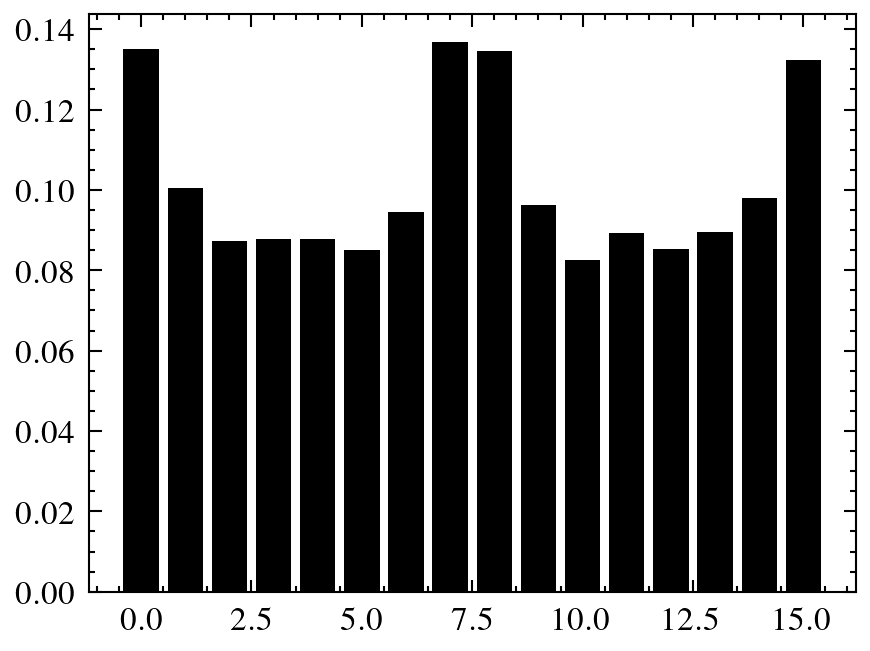

In [20]:

vals = ax.hist2d(data,m, bins=16, weights=m)
unweighted_vals = ax.hist2d(data,m, bins=16)

w_counts = vals[0]

uw_counts = unweighted_vals[0]

sum_intensities = tf.reduce_sum(w_counts, axis=1)/tf.reduce_sum(uw_counts, axis=1)
#plt.bar(sum_intensities, vals[1])
vals[1].shape
plt.bar(list(range(16)), sum_intensities)

(array([843.92236328, 593.48834229, 428.13711548, 314.4934082 ,
        258.11584473, 237.53253174, 230.13883972, 243.13705444,
        227.53457642, 244.06970215, 243.17825317, 253.449646  ,
        291.0246582 , 395.6267395 , 614.86505127, 864.22149658,
        880.53015137, 589.01898193, 407.13562012, 288.93566895,
        249.66323853, 212.47698975, 234.50491333, 235.26521301,
        238.69577026, 217.86480713, 246.04386902, 257.46917725,
        309.01751709, 391.17715454, 583.75378418, 853.52233887]),
 array([-3.1414773e+00, -2.9451315e+00, -2.7487860e+00, -2.5524402e+00,
        -2.3560944e+00, -2.1597486e+00, -1.9634029e+00, -1.7670572e+00,
        -1.5707114e+00, -1.3743656e+00, -1.1780199e+00, -9.8167413e-01,
        -7.8532839e-01, -5.8898264e-01, -3.9263690e-01, -1.9629115e-01,
         5.4597855e-05,  1.9640034e-01,  3.9274609e-01,  5.8909184e-01,
         7.8543758e-01,  9.8178333e-01,  1.1781291e+00,  1.3744748e+00,
         1.5708206e+00,  1.7671664e+00,  1.9635121e+00

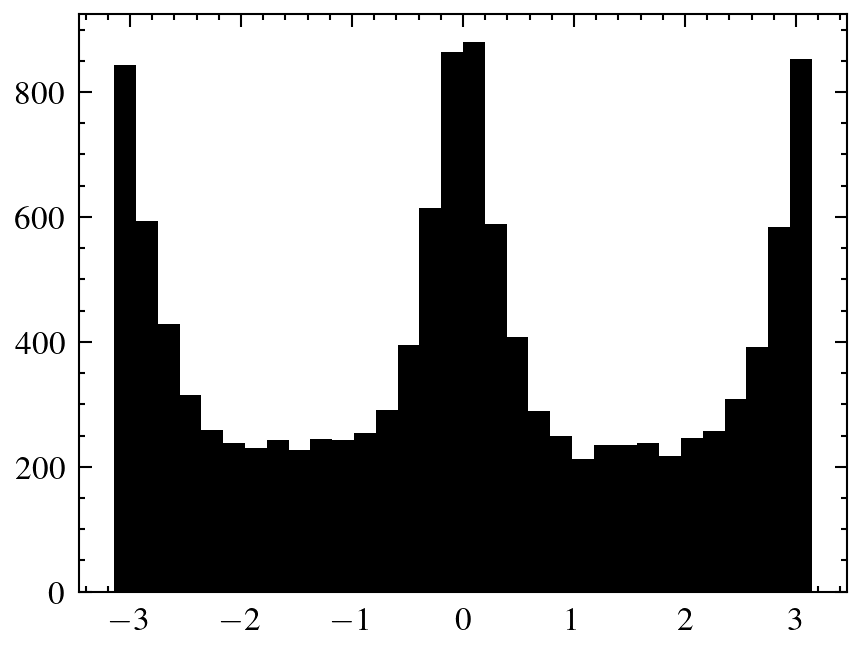

In [19]:
plt.hist(data, bins=32, weights=m)

(array([11153.,  6226.,  3798.,  3285.,  3426.,  4258.,  6907., 13409.,
        13261.,  6894.,  4311.,  3353.,  3181.,  4020.,  6143., 11434.]),
 array([-3.1415658e+00, -2.7488697e+00, -2.3561735e+00, -1.9634775e+00,
        -1.5707814e+00, -1.1780852e+00, -7.8538913e-01, -3.9269301e-01,
         3.0994415e-06,  3.9269921e-01,  7.8539532e-01,  1.1780914e+00,
         1.5707875e+00,  1.9634837e+00,  2.3561797e+00,  2.7488759e+00,
         3.1415720e+00], dtype=float32),
 <BarContainer object of 16 artists>)

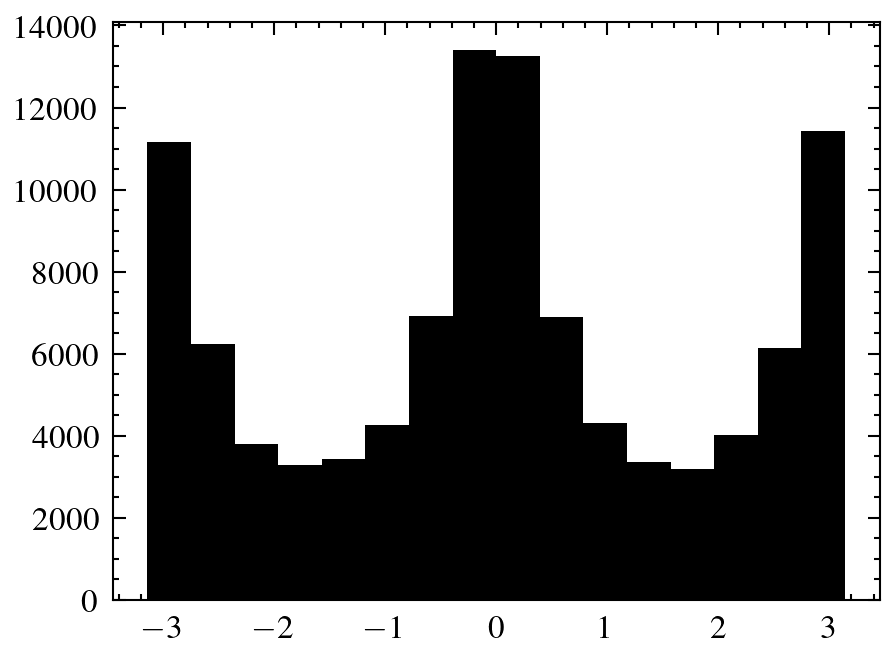

In [11]:
plt.hist(data, bins=16)

In [12]:
weight.shape

(105059,)

(array([1662.01977539,  560.82702637,  279.53851318,  233.13514709,
         248.58216858,  336.02526855,  694.78393555, 2182.16723633,
        2160.59033203,  705.28826904,  331.47909546,  240.00317383,
         221.46783447,  295.15444946,  575.33270264, 1692.58691406]),
 array([-3.1415658e+00, -2.7488697e+00, -2.3561735e+00, -1.9634775e+00,
        -1.5707814e+00, -1.1780852e+00, -7.8538913e-01, -3.9269301e-01,
         3.0994415e-06,  3.9269921e-01,  7.8539532e-01,  1.1780914e+00,
         1.5707875e+00,  1.9634837e+00,  2.3561797e+00,  2.7488759e+00,
         3.1415720e+00], dtype=float32),
 <BarContainer object of 16 artists>)

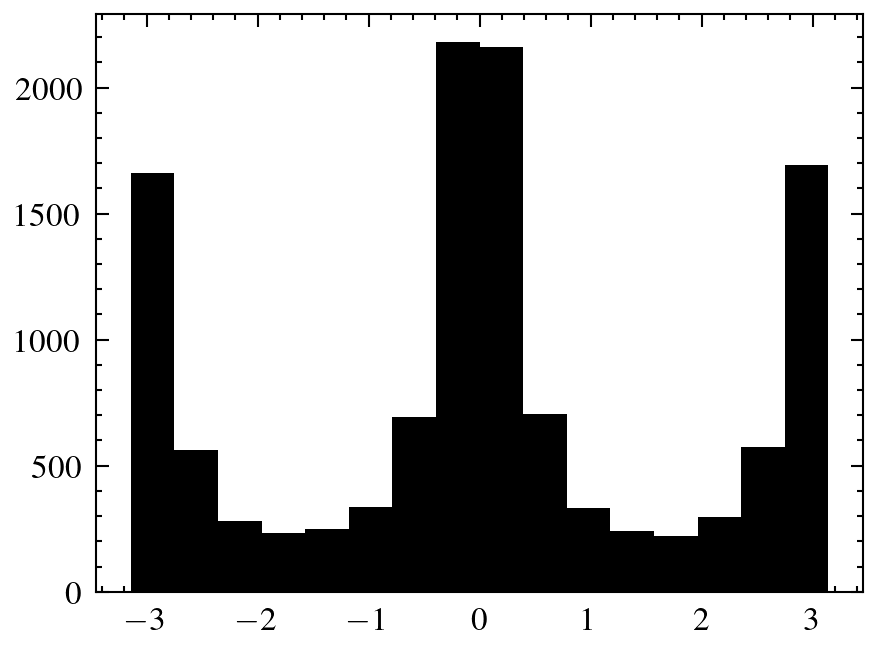

In [13]:
plt.hist(data, bins=16, weights=weight)